In [2]:
import glob
import json
import os

import pandas as pd

In [3]:
# PyTorch
import matplotlib.pyplot as plt

# Matrix operations
import numpy as np
import torch
import torchvision

# Loading dataset
from datasets import load_dataset

# For dislaying images
from PIL import Image

# Evaluation
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from torchvision.transforms import Compose, Normalize, Resize, ToPILImage, ToTensor

# Transformers
from transformers import (
    Trainer,
    TrainingArguments,
    ViTForImageClassification,
    ViTImageProcessor,
)

In [4]:
def create_object_detection_dataset(img_file, label_file):
    img = Image.open(img_file)
    bbox_list = []
    categories = []
    try:
        img_bbox_df = pd.read_csv(
            label_file, sep=" ", header=None, usecols=[1, 2, 3, 4]
        )
        width, height = img.size
        for _, row in img_bbox_df.iterrows():
            bx, by, bw, bh = row.values
            orig_bx, orig_bw = bx * width, bw * width
            orig_by, orig_bh = by * height, bh * height
            bbox_list.append(
                [
                    round(orig_bx, 2),
                    round(orig_by, 2),
                    round(orig_bw, 2),
                    round(orig_bh, 2),
                ]
            )
            categories.append(0)

    except pd.errors.EmptyDataError:
        print(f"No label found {label_file}")

    return {
        "file_name": "shrimp/" + os.path.basename(img.filename),
        "objects": {"bbox": bbox_list, "categories": categories},
    }


# Creates huggingface DataSet object from Open-Image data
def generate_metadata_csv():
    ultralytics_data_dir = "/Users/javkhlan-ochirganbat/repos/machine-learning/underwater_object/data/open-images-v7"
    shrimp_img_dir = "./data"

    for subdir in ["train", "test"]:
        bbox_jsonl = []
        data_dir = os.path.join(ultralytics_data_dir, subdir)
        for label_file in sorted(
            glob.glob(os.path.join(data_dir, "labels", "shrimp/*.txt"))
        ):
            basename = os.path.basename(label_file).removesuffix(".txt")
            img_file = os.path.join(data_dir, "images/shrimp", basename + ".jpg")
            bbox_jsonl.append(create_object_detection_dataset(img_file, label_file))

        with open(
            os.path.join(shrimp_img_dir, subdir, "metadata.jsonl"), "w"
        ) as outfile:
            for json_dict in bbox_jsonl:
                outfile.write(json.dumps(json_dict) + "\n")


# generate_metadata_csv()

In [5]:
shrimp_img_dir = "./data"
shrimp_dataset = load_dataset("imagefolder", data_dir=shrimp_img_dir, drop_labels=False)

# Data pre-processing

trainds, testds = shrimp_dataset["train"], shrimp_dataset["test"]
valds = testds
trainds, valds, testds

Resolving data files:   0%|          | 0/618 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/211 [00:00<?, ?it/s]

(Dataset({
     features: ['image', 'label', 'objects'],
     num_rows: 617
 }),
 Dataset({
     features: ['image', 'label', 'objects'],
     num_rows: 210
 }),
 Dataset({
     features: ['image', 'label', 'objects'],
     num_rows: 210
 }))

In [6]:
itos = dict((k, v) for k, v in enumerate(trainds.features["label"].names))
stoi = dict((v, k) for k, v in enumerate(trainds.features["label"].names))
itos

{0: 'shrimp'}

In [7]:
def adjust_image(img_file, label_file):
    img = Image.open(img_file)
    try:
        img_bbox_df = pd.read_csv(
            label_file, sep=" ", header=None, usecols=[1, 2, 3, 4]
        )
        width, height = img.size
        length = min(width, height)
        farthest_x, farthest_y = 0, 0
        for _, row in img_bbox_df.iterrows():
            bx, by, bw, bh = row.values
            orig_bx, orig_bw = bx * width, bw * width
            orig_by, orig_bh = by * height, bh * height
            farthest_x = max(farthest_x, int(orig_bx + orig_bw / 2))
            farthest_y = max(farthest_y, int(orig_by + orig_bh / 2))

        x1, y1 = 0, 0
        if height > width:
            if length < farthest_y:
                y1 = height - length
        else:
            if length < farthest_x:
                x1 = width - length

        cropped_img = img.crop((x1, y1, x1 + length, y1 + length))

    except pd.errors.EmptyDataError:
        print(f"No label found {label_file}")
        cropped_img = img.crop((0, 0, length, length))

        cropped_img = img

    cropped_img.save(img_file)

    return cropped_img

In [8]:
# for img_file in sorted(glob.glob("data/train/shrimp/*.jpg")):
#     label_file = f"../underwater_object/data/open-images-v7/train/labels/shrimp/{os.path.basename(img_file).replace('.jpg', '.txt')}"
#     adjust_image(img_file, label_file)

In [9]:
# Model from huggingface
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

mu, sigma = processor.image_mean, processor.image_std  # get default mu,sigma
size = processor.size
size

{'height': 224, 'width': 224}

In [10]:
norm = Normalize(mean=mu, std=sigma)  # normalize image pixels range to [-1,1]

# resize 3x32x32 to 3x224x224 -> convert to Pytorch tensor -> normalize
_transf = Compose([Resize(size["height"]), ToTensor(), norm])

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg["pixels"] = [_transf(image.convert("RGB")) for image in arg["image"]]
    return arg

In [11]:
trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

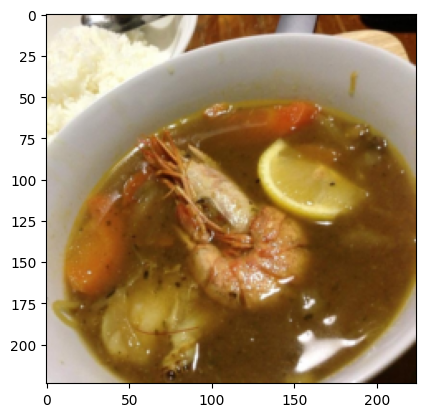

In [12]:
ex = trainds[15]["pixels"]
ex = (ex + 1) / 2  # imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

In [13]:
model = ViTForImageClassification.from_pretrained(model_name)
# initial model was trained on 1000 labels
print(model.classifier)

Linear(in_features=768, out_features=1000, bias=True)


In [14]:
# Limit the classes to just 10 for CIFAR 10
model = ViTForImageClassification.from_pretrained(
    model_name, num_labels=1, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi
)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=1, bias=True)


In [15]:
args = TrainingArguments(
    "test-open-image-v7",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="logs",
    remove_unused_columns=False,
    use_cpu=True
)

In [16]:
def collate_fn(examples):
    """
    Stacks pixels values on top of each others and create tensors for labels
    """
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [17]:
# Trainer object
trainer = Trainer(
    model,
    args,
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [18]:
trainer.train()

RuntimeError: Found dtype Long but expected Float

In [ ]:
outputs = trainer.predict(testds)
print(outputs.metrics)

In [ ]:
for i in range(10):
    print(itos[np.argmax(outputs.predictions[i])], itos[outputs.label_ids[i]])

In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = trainds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [19]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )


Detected cat with confidence 0.998 at location [344.06, 24.85, 640.34, 373.74]
Detected remote with confidence 0.997 at location [328.13, 75.93, 372.81, 187.66]
Detected remote with confidence 0.997 at location [39.34, 70.13, 175.56, 118.78]
Detected cat with confidence 0.998 at location [15.36, 51.75, 316.89, 471.16]
Detected couch with confidence 0.995 at location [-0.19, 0.71, 639.73, 474.17]
